In [8]:
import os
import numpy as np
import typing as t
from glob import glob
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from v1t.utils import utils, yaml, tensorboard

utils.set_random_seed(1234)

tensorboard.set_font()

TRAIN_SIZES = [500, 1500, 2500, 3500, 4500]

In [7]:
def get_results(dir: str):
    results = {}
    for train_size in TRAIN_SIZES:
        if train_size not in results:
            results[train_size] = {}
        for model in ["stacked2d", "v1t"]:
            if model not in results[train_size]:
                results[train_size][model] = []
            output_dirs = glob(os.path.join(dir, str(train_size), model, "*"))
            for output_dir in output_dirs:
                filename = os.path.join(output_dir, "evaluation.yaml")
                if os.path.exists(filename):
                    result = yaml.load(filename)
                    results[train_size][model].append(
                        result["single_trial_correlation"]["average"]
                    )
    return results


results = get_results("../runs/limit_data")

In [13]:
def p_value_to_asterisks(p_value: float):
    text = "n.s."
    if p_value <= 0.0001:
        text = "****"
    elif p_value <= 0.001:
        text = "***"
    elif p_value <= 0.01:
        text = "**"
    elif p_value <= 0.05:
        text = "*"
    return text


def get_summary(results: t.Dict[int, t.Dict[str, t.List[float]]]):
    summary = {
        "cnn": {"mean": [], "std": []},
        "v1t": {"mean": [], "std": []},
        "p_values": [],
    }
    for train_size, result in results.items():
        cnn, v1t = result["stacked2d"], result["v1t"]
        if len(cnn) != len(v1t):
            print(
                f"V1T and CNN (train size: {train_size}) have different number of experiments: {len(v1t)} vs {len(cnn)}."
            )
        summary["cnn"]["mean"].append(np.mean(cnn))
        summary["cnn"]["std"].append(np.std(cnn))
        summary["v1t"]["mean"].append(np.mean(v1t))
        summary["v1t"]["std"].append(np.std(v1t))
        t_test = ttest_ind(cnn, v1t)
        summary["p_values"].append(p_value_to_asterisks(t_test.pvalue))
    return summary


summary = get_summary(results)
print(summary)

V1T and CNN (train size: 1500) have different number of experiments: 18 vs 30.
V1T and CNN (train size: 2500) have different number of experiments: 14 vs 30.
V1T and CNN (train size: 3500) have different number of experiments: 12 vs 30.
{'cnn': {'mean': [0.20466250131527583, 0.3135744591554006, 0.3596112817525864, 0.37537760436534884, 0.3808719595273336], 'std': [0.012091990787003109, 0.008790647899131908, 0.005445721750220828, 0.004509631536167693, 0.004363944216821465]}, 'v1t': {'mean': [0.15932507514953614, 0.32539818187554675, 0.3779355670724596, 0.4068212832013766, 0.4222335974375407], 'std': [0.019002588879335577, 0.007765431732082184, 0.007586265910194501, 0.003354352205925333, 0.0024657900246291948]}, 'p_values': ['****', '****', '****', '****', '****']}


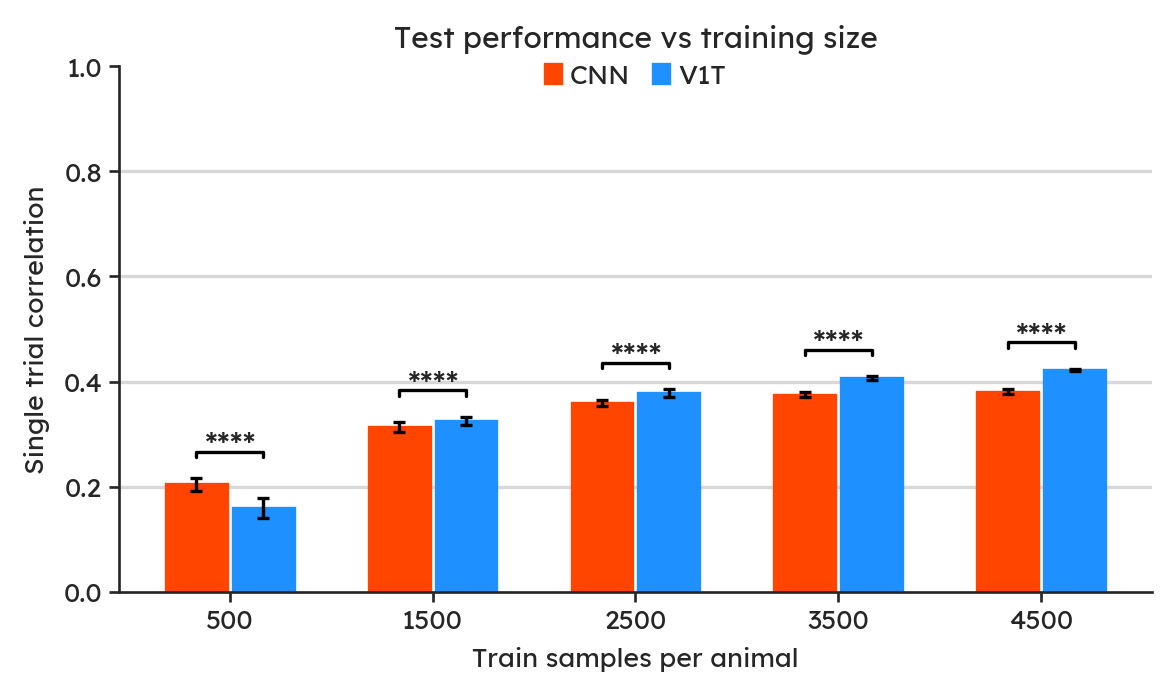

In [56]:
annot_fontsize, tick_fontsize, label_fontsize, title_fontsize = 7, 8, 8, 9
width, y_max, bar_pad = 0.3, 1.0, 0.015
error_kw = {"elinewidth": 1, "capsize": 1.8}
figure, axis = plt.subplots(
    nrows=1, ncols=1, figsize=(5, 3), dpi=240, facecolor="white"
)

x_axis = np.arange(1, len(TRAIN_SIZES) + 1)
x_labels = TRAIN_SIZES

# plot CNN results
cnn_mean, cnn_std = summary["cnn"]["mean"], summary["cnn"]["std"]
axis.bar(
    x_axis - width / 2 - bar_pad,
    height=cnn_mean,
    yerr=cnn_std,
    width=width,
    align="center",
    label="CNN",
    color="orangered",
    edgecolor="orangered",
    error_kw=error_kw,
)

# plot V1T results
v1t_mean, v1t_std = summary["v1t"]["mean"], summary["v1t"]["std"]
axis.bar(
    x_axis + width / 2 + bar_pad,
    height=v1t_mean,
    yerr=v1t_std,
    width=width,
    align="center",
    label="V1T",
    color="dodgerblue",
    edgecolor="dodgerblue",
    error_kw=error_kw,
)

axis.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncols=2,
    frameon=False,
    handletextpad=0.35,
    handlelength=0.6,
    markerscale=0.8,
    columnspacing=0.85,
    fontsize=label_fontsize,
)

tensorboard.set_xticks(
    axis,
    ticks_loc=x_axis,
    ticks=x_labels,
    label="Train samples per animal",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
axis.set_ylim(0, y_max)
y_ticks = np.linspace(0, y_max, 6)
tensorboard.set_yticks(
    axis,
    ticks_loc=y_ticks,
    ticks=y_ticks.round(1),
    label="Single trial correlation",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
sns.despine(ax=axis, top=True, right=True, trim=False)
# plot y-axis grid lines
for y_value in y_ticks:
    if 0 < y_value < y_max:
        axis.axhline(y_value, color="gray", alpha=0.3, linewidth=1, zorder=0)

# plot p-value asterisks
for i in range(len(TRAIN_SIZES)):
    x_start = x_axis[i]
    mid = width / 2
    lx = x_start - mid - bar_pad
    rx = x_start + mid + bar_pad
    y = max(v1t_mean[i] + v1t_std[i], cnn_mean[i] + cnn_std[i]) + 0.04
    barx = [lx, lx, rx, rx]
    y_offset = 0.01
    bary = [y, y + y_offset, y + y_offset, y]
    plt.plot(barx, bary, color="black", linewidth=1)
    plt.text(
        x=(lx + rx) / 2,
        y=y - 0.01,
        s=summary["p_values"][i],
        ha="center",
        va="bottom",
    )

axis.set_title("Test performance vs training size", fontsize=title_fontsize, y=1)

figure.tight_layout()

tensorboard.save_figure(figure, filename=f"plots/limit_data.jpg", dpi=240, close=False)

plt.show()
plt.close(figure)